### Load Packages

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt
import math
import seaborn as sns

# Import Custom Module
import OeconToolbox as ott

%load_ext autoreload
%autoreload 2
%matplotlib inline

### [OPTIONAL] Set Matplotlib Style

In [47]:
matplotlib.style.use('default')

matplotlib.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 10})
matplotlib.path.should_simplify = True

sns.set_style("ticks")

cm = 1/2.54
textwidth = 13.998 / 2.54

## Import Cumulative Default Table

In [5]:
DefTable = pd.read_excel("CumulativeDefaultTable.xlsx",header=[0],index_col=[0],skipfooter=5,usecols="A:K")
DefTable.round(2)

,1,2,3,4,5,6,7,8,9,10
AAA,0.00,0.03,0.10,0.19,0.27,0.37,0.41,0.46,0.52,0.58
AA,0.02,0.06,0.11,0.21,0.30,0.41,0.49,0.56,0.63,0.70
A,0.05,0.13,0.22,0.33,0.46,0.60,0.76,0.90,1.05,1.20
BBB,0.16,0.43,0.75,1.14,1.54,1.94,2.27,2.61,2.94,3.24
BB,0.63,1.93,3.46,4.99,6.43,7.75,8.89,9.90,10.82,11.64
B,3.34,7.80,11.75,14.89,17.35,19.36,20.99,22.31,23.50,24.62


# Simulating a Portfolio of loans
The SPV portfolio consists of $J$ loans from identical corporate issuers with a single class of debt outstanding. The parameters of the issuers is identical to those described in the 'Collateral Dynamics.ipynb' notebook.

## Parameters of the Corporate Issuers

In [1]:
V0 = 100      # Initial Asset Value
rf = .035     # Risk-Free Rate
rm = .105     # Market Return
beta = .8     # Firm CAPM Coefficient
sigma_i = .25 # Idiosyncratic Risk
sigma_m = .14 # Market Risk
ttm = 5       # Time to Maturity of Debt

Auxiliary Calculations

In [6]:
mu = rf + beta * (rm - rf)
sigma = ott.sigma_beta_adj(beta, sigma_m, sigma_i)
face_value = ott.facevalue_from_probability(DefTable.loc["B", ttm] / 100, V0, ttm, mu, sigma)
market_value = ott.mv_bond(V0, face_value, ttm, rf, sigma)

## Parameters of the SPV

In [18]:
J = 125    # number of loans
N = 250000 # Number of simulated portfolios

# Modelling the SPV Dynamics without Prepayment on Collateral Assets

In [22]:
max_spv_cash_flows = face_value * J
initial_market_value = market_value * J
print("The absolute maximum payoff: {0:0.2f} with initial market value: {1:0.2f}".format(max_spv_cash_flows,initial_market_value))

The absolute maximum payoff: 9180.30 with initial market value: 6990.38


A wrapper function for the equilibrium value of the loan portfolio

In [16]:
def Dk(face_val):
    Dk, M = ott.loan_portfolio(j = J,
                               n = N,
                               V = V0,
                               B = face_value,
                               T = ttm,
                               rf = rf,
                               rm = rm,
                               beta = beta,
                               sigmaI = sigma_i,
                               sigmaM = sigma_m,
                               risk_neutral=True,
                               paths=False)
    return Dk

Total SPV payoffs (under Q-measure)

In [20]:
SPV_Q = Dk(face_value)

Total SPV payoffs (under P-measure)

In [21]:
SPV_P, M = ott.loan_portfolio(j = J,
                              n = 250000,
                              V = V0,
                              B = face_value,
                              T = ttm,
                              rf = rf,
                              rm = rm,
                              beta = beta,
                              sigmaI = sigma_i,
                              sigmaM = sigma_m,
                              risk_neutral=False,
                              paths=False)

In [24]:
tmp, tranches = np.zeros(7), np.zeros(7)
i = 0
for rating, def_prob in DefTable[ttm].items(): 
    tmp[i]  = np.quantile(SPV_P, def_prob/100)
    if i == 0 : tranches[i] = np.quantile(SPV_P, def_prob/100)
    else: tranches[i] = np.quantile(SPV_P, def_prob/100) - tmp[i-1].sum(axis=0)
    i = i + 1
tranches[i] = np.quantile(SPV_P, 1) - tmp[i-1].sum(axis=0)

## Cash Flows to each Tranche

In [33]:
pd.DataFrame(tranches,["AAA","AA","A","BBB","BB","B","Equity"],columns=['Cash Flows'])

,Cash Flows
AAA,7233.123926
AA,32.553669
A,125.585199
BBB,358.089939
BB,442.005521
B,317.878967
Equity,671.062623


AAA 0.27 7233
AA 0.3 7265
A 0.46 7391
BBB 1.54 7749
BB 6.43 8191
B 17.35 8509


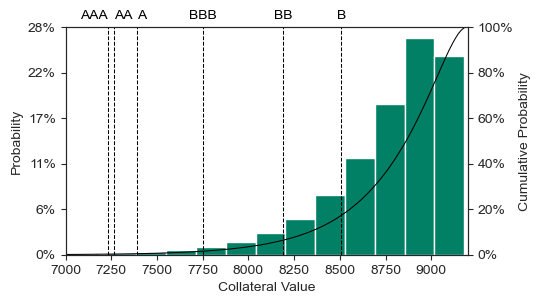

In [50]:
plt.figure(figsize=(textwidth, 8*cm))
palette = sns.color_palette("summer", n_colors=6, as_cmap=True)

simulations = SPV_P

min_ = 7000
max_ = 9200
ax = sns.histplot(data=simulations, bins=25, color=palette(1), stat='probability', alpha=1)
plt.ylabel("Probability")
maxy = round(ax.get_ylim()[1],2)

plt.ylim([0, maxy])
plt.yticks(np.linspace(0, maxy, 6),[str(int(round(x,2)*100))+"%" for x in np.linspace(0, maxy, 6)])

plt.xlim([min_,max_])
plt.xlabel("Collateral Value")

for rating, def_prob in DefTable[ttm].items(): 
    value = np.quantile(simulations, def_prob/100)
    print(rating,def_prob,int(value))
    plt.vlines(value,0,maxy*1.05,color='k',linestyles='--',linewidth=0.75)
    if rating == 'AAA':
        plt.text(value,maxy*1.05,s=rating,ha='right',va='center',color='k')
    elif rating == 'AA' or rating == 'A':
        plt.text(value,maxy*1.05,s=rating,ha='left',va='center',color='k')
    else:
        plt.text(value,maxy*1.05,s=rating,ha='center',va='center',color='k')

ax2 = ax.twinx()
ax2 = sns.ecdfplot(data=simulations, color='k',linewidth=0.75, ax=ax2, stat='proportion')
plt.ylabel("Cumulative Probability")
plt.ylim([0,1])
plt.yticks(np.linspace(0, 1, 6),["0%","20%","40%","60%","80%","100%"])

plt.tight_layout()
plt.show()
#plt.savefig("pic.pdf", format='pdf', bbox_inches='tight')

Data For Scatterplots

In [59]:
SPV_P_small = np.random.RandomState(1234).choice(SPV_P,size=2500)
M_small = np.random.RandomState(1234).choice(M,size=2500)

In [60]:
scatter_data = pd.DataFrame({'SPV':SPV_P_small/ max_spv_cash_flows,
                             'Market Factor':M_small / 5,
                             'AAA':ott.clo_payoffs(SPV_P_small,tranches)[0]/ tranches[0],
                             'AA':ott.clo_payoffs(SPV_P_small,tranches)[1]/ tranches[1],
                             'A':ott.clo_payoffs(SPV_P_small,tranches)[2] / tranches[2],
                             'BBB':ott.clo_payoffs(SPV_P_small,tranches)[3] / tranches[3],
                             'BB':ott.clo_payoffs(SPV_P_small,tranches)[4] / tranches[4],
                             'B':ott.clo_payoffs(SPV_P_small,tranches)[5] / tranches[5],
                             'Equity':ott.clo_payoffs(SPV_P_small,tranches)[6]/ tranches[6]})
scatter_data

,SPV,Market Factor,AAA,AA,A,BBB,BB,B,Equity
0,0.990824,0.249813,1.0,1.0,1.0,1.0,1.0,1.0,0.874467
1,0.982318,0.007552,1.0,1.0,1.0,1.0,1.0,1.0,0.758100
2,0.976469,0.196481,1.0,1.0,1.0,1.0,1.0,1.0,0.678097
3,0.964409,-0.136603,1.0,1.0,1.0,1.0,1.0,1.0,0.513102
4,0.982938,0.328542,1.0,1.0,1.0,1.0,1.0,1.0,0.766591
...,...,...,...,...,...,...,...,...,...
2495,0.979048,0.134932,1.0,1.0,1.0,1.0,1.0,1.0,0.713368
2496,0.968940,0.348749,1.0,1.0,1.0,1.0,1.0,1.0,0.575085
2497,0.983798,0.594158,1.0,1.0,1.0,1.0,1.0,1.0,0.778358
2498,0.939418,-0.309687,1.0,1.0,1.0,1.0,1.0,1.0,0.171217


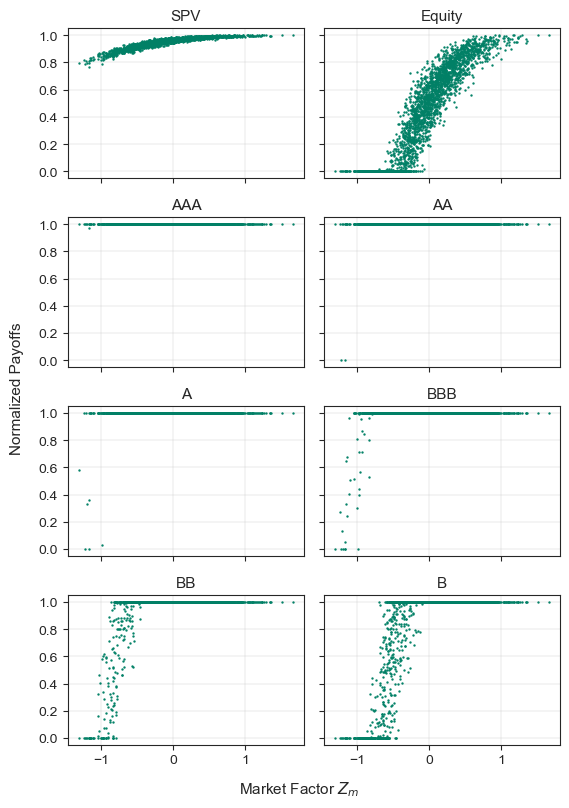

In [61]:
fig, axs = plt.subplots(ncols=2,nrows=4,sharex=True,sharey=True)

palette = sns.color_palette("summer", n_colors=6, as_cmap=True)

fig.text(0.5, -0.015, 'Market Factor $Z_{m}$', ha='center', size=11)
fig.text(-0.025, 0.5, 'Normalized Payoffs', va='center', rotation='vertical', size=11)

i,j = 0,0
for tranche in ["Equity","SPV","AA","AAA","BBB","A","B","BB"]:
    if j == 0: j = 1
    else: j = 0
    axs[i,j].scatter(x=scatter_data['Market Factor'], y = scatter_data[tranche], s= 0.5, color=palette(1))
    #axs[i,j].scatter(x=scatter_data2['Market Factor'], y = scatter_data2[tranche], s= 0.5, color='red')
    axs[i,j].set_title(tranche, size=11)
    axs[i,j].set_xlabel('')
    axs[i,j].set_ylabel('')
    axs[i,j].set_ylim([-0.05,1.05])
    axs[i,j].set_yticks([0,0.2,0.4,0.6,0.8,1])
    axs[i,j].grid(lw=0.3)
    if j == 0: i = i + 1

fig.set_size_inches(textwidth, 20*cm)
fig.tight_layout()

plt.show()

#fig.savefig("Payoffs.png", bbox_inches='tight', format='png', dpi=600)